# Solar Orbiter
This example demonstrates a ballistic model inspired by the solar orbiter mission.

In [2]:
# Pykep imports
from pykep.trajopt import mga_1dsm, launchers
from pykep.planet import jpl_lp
from pykep import epoch
from pykep.core import lambert_problem, propagate_lagrangian, fb_prop
from pykep import DAY2SEC, DAY2YEAR, AU, RAD2DEG, ic2par
from pykep.trajopt.gym._solar_orbiter import _solar_orbiter_udp

# Other imports
import numpy as np
from numpy.linalg import norm
from math import acos, asin, cos, exp, log, pi, sin, 
from copy import deepcopy
import pygmo
import time

In [6]:
# define search window
tmin = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 - 2*365)
tmax = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 + 2*365)

In [7]:
solar_orbiter = _solar_orbiter_udp([tmin, tmax])

In [8]:
# Include delta v, mass and sun distance constraints
prob = pygmo.unconstrain(pygmo.problem(solar_orbiter),method="weighted",weights=[1.0, 10.0, 100, 100])

In [9]:
# define problem and algorithm
pop = pygmo.population(prob=prob, size=50)
alg = pygmo.algorithm(pygmo.sade(memory=True,gen=1))

In [11]:
# run evolution
for i in range(3000):
    pop = alg.evolve(pop)
    print(i, pop.champion_f, solar_orbiter.fitness(pop.champion_x))

0 [25248.06187697] [1.3725409374176643, 23157.689336032498, array([208.9]), -0.23355806584902683, -0.19999999999999996]
1 [25248.06187697] [1.3725409374176643, 23157.689336032498, array([208.9]), -0.23355806584902683, -0.19999999999999996]
2 [25248.06187697] [1.3725409374176643, 23157.689336032498, array([208.9]), -0.23355806584902683, -0.19999999999999996]
3 [24126.4605826] [1.4332806084124905, 22036.027301988994, array([208.9]), -0.39547949676369853, -0.19999999999999996]
4 [24126.4605826] [1.4332806084124905, 22036.027301988994, array([208.9]), -0.39547949676369853, -0.19999999999999996]
5 [23546.85092355] [1.5201123662061842, 21456.33081118056, array([208.9]), -0.36511313360911213, -0.19999999999999996]
6 [23546.85092355] [1.5201123662061842, 21456.33081118056, array([208.9]), -0.36511313360911213, -0.19999999999999996]
7 [10943.01008928] [1.5010820201783468, 8852.509007259676, array([208.9]), -0.242463850961265, -0.19999999999999996]
8 [10943.01008928] [1.5010820201783468, 8852.50

73 [4686.53174774] [1.4984718281560223, 2596.0332759151206, array([208.9]), -0.29520210798302626, -0.19999999999999996]
74 [4686.53174774] [1.4984718281560223, 2596.0332759151206, array([208.9]), -0.29520210798302626, -0.19999999999999996]
75 [4686.53174774] [1.4984718281560223, 2596.0332759151206, array([208.9]), -0.29520210798302626, -0.19999999999999996]
76 [4686.53174774] [1.4984718281560223, 2596.0332759151206, array([208.9]), -0.29520210798302626, -0.19999999999999996]
77 [2123.94434012] [1.494986077765522, 2122.44935404064, array([-1931.68610689]), -0.2532479895096774, -0.19823154505243257]
78 [2123.94434012] [1.494986077765522, 2122.44935404064, array([-1931.68610689]), -0.2532479895096774, -0.19823154505243257]
79 [2123.94434012] [1.494986077765522, 2122.44935404064, array([-1931.68610689]), -0.2532479895096774, -0.19823154505243257]
80 [2123.94434012] [1.494986077765522, 2122.44935404064, array([-1931.68610689]), -0.2532479895096774, -0.19823154505243257]
81 [2123.94434012] [

138 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
139 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
140 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
141 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
142 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
143 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
144 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078, -0.19842367130848193]
145 [1468.94911283] [1.4446390076493159, 1467.5044738221832, array([-391.71747192]), -0.2965378212770078

202 [1144.431709] [1.4187643353711736, 1143.0129446694546, array([-391.71747192]), -0.26733490087444434, -0.19842367130848193]
203 [1144.431709] [1.4187643353711736, 1143.0129446694546, array([-391.71747192]), -0.26733490087444434, -0.19842367130848193]
204 [1144.431709] [1.4187643353711736, 1143.0129446694546, array([-391.71747192]), -0.26733490087444434, -0.19842367130848193]
205 [1144.431709] [1.4187643353711736, 1143.0129446694546, array([-391.71747192]), -0.26733490087444434, -0.19842367130848193]
206 [1144.431709] [1.4187643353711736, 1143.0129446694546, array([-391.71747192]), -0.26733490087444434, -0.19842367130848193]
207 [1144.41749204] [1.4045473751969235, 1143.0129446694546, array([-391.71747192]), -0.21727928097533128, -0.19842367130848193]
208 [1144.41749204] [1.4045473751969235, 1143.0129446694546, array([-391.71747192]), -0.21727928097533128, -0.19842367130848193]
209 [1144.41749204] [1.4045473751969235, 1143.0129446694546, array([-391.71747192]), -0.21727928097533128, 

271 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
272 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
273 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
274 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
275 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
276 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
277 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]
278 [748.13613943] [1.3809548843350619, 746.7551845410508, array([-1783.558013]), -0.18931481594223543, -0.1694487722960467]


340 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
341 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
342 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
343 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
344 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
345 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
346 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
347 [748.13305507] [1.3778705247186847, 746.7551845410508, array([-1783.558013]), -0.1902887664689643, -0.1694487722960467]
348 [748

406 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
407 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
408 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
409 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
410 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
411 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
412 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.1984483803620256]
413 [398.23018946] [1.3859234067742903, 396.8442660554474, array([-1933.84471283]), -0.24828312564449995, -0.19

471 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
472 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
473 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
474 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
475 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
476 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
477 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]
478 [377.27628516] [1.38473990270533, 375.89154525511276, array([-1933.84471283]), -0.2234140320673338, -0.1984483803620256]


540 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
541 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
542 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
543 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
544 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
545 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
546 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.23506996590726736, -0.19824423548333225]
547 [204.11145912] [1.3831024483250263, 202.72835667490563, array([-1929.46239973]), -0.235069965

605 [52.09127745] [1.383227590089777, 50.708049856890526, array([-1933.84471283]), -0.25462451740743475, -0.1984483803620256]
606 [52.09127745] [1.383227590089777, 50.708049856890526, array([-1933.84471283]), -0.25462451740743475, -0.1984483803620256]
607 [52.09127711] [1.3832272530165277, 50.708049856890526, array([-1933.84471283]), -0.25462461701696915, -0.1984483803620256]
608 [52.09127711] [1.3832272530165277, 50.708049856890526, array([-1933.84471283]), -0.25462461701696915, -0.1984483803620256]
609 [52.09127711] [1.3832272530165277, 50.708049856890526, array([-1933.84471283]), -0.25462461701696915, -0.1984483803620256]
610 [52.09127711] [1.3832272530165277, 50.708049856890526, array([-1933.84471283]), -0.25462461701696915, -0.1984483803620256]
611 [52.09127711] [1.3832272530165277, 50.708049856890526, array([-1933.84471283]), -0.25462461701696915, -0.1984483803620256]
612 [52.09127711] [1.3832272530165277, 50.708049856890526, array([-1933.84471283]), -0.25462461701696915, -0.1984

674 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
675 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
676 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
677 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
678 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
679 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
680 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803620256]
681 [52.09127647] [1.3832266153028443, 50.708049856890526, array([-1933.84471283]), -0.2546248054706973, -0.1984483803

741 [52.09127646] [1.3832266003571294, 50.708049856890526, array([-1933.84471283]), -0.2546248098873912, -0.1984483803620256]
742 [52.09127646] [1.3832266003571294, 50.708049856890526, array([-1933.84471283]), -0.2546248098873912, -0.1984483803620256]
743 [52.09127646] [1.3832266003571294, 50.708049856890526, array([-1933.84471283]), -0.2546248098873912, -0.1984483803620256]
744 [52.09127646] [1.3832266003571294, 50.708049856890526, array([-1933.84471283]), -0.2546248098873912, -0.1984483803620256]
745 [52.09127646] [1.3832266003571294, 50.708049856890526, array([-1933.84471283]), -0.2546248098873912, -0.1984483803620256]
746 [52.09127646] [1.3832266003571294, 50.708049856890526, array([-1933.84471283]), -0.2546248098873912, -0.1984483803620256]
747 [52.09083362] [1.3827837598884656, 50.708049856890526, array([-1933.84471283]), -0.24557508450675647, -0.1984483803620256]
748 [52.09083362] [1.3827837598884656, 50.708049856890526, array([-1933.84471283]), -0.24557508450675647, -0.19844838

809 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
810 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
811 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
812 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
813 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
814 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
815 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.1984483803620256]
816 [52.09083362] [1.3827837598196626, 50.708049856890526, array([-1933.84471283]), -0.24557508452355148, -0.19

878 [52.09083362] [1.3827837596257349, 50.708049856890526, array([-1933.84471283]), -0.2455750845708894, -0.1984483803620256]
879 [52.09083362] [1.3827837596257349, 50.708049856890526, array([-1933.84471283]), -0.2455750845708894, -0.1984483803620256]
880 [52.09083362] [1.3827837596257349, 50.708049856890526, array([-1933.84471283]), -0.2455750845708894, -0.1984483803620256]
881 [52.09083362] [1.382783759620469, 50.708049856890526, array([-1933.84471283]), -0.24557508457217458, -0.1984483803620256]
882 [52.09083362] [1.382783759620469, 50.708049856890526, array([-1933.84471283]), -0.24557508457217458, -0.1984483803620256]
883 [52.09083362] [1.382783759620469, 50.708049856890526, array([-1933.84471283]), -0.24557508457217458, -0.1984483803620256]
884 [52.09083362] [1.382783759620469, 50.708049856890526, array([-1933.84471283]), -0.24557508457217458, -0.1984483803620256]
885 [52.09083362] [1.382783759620469, 50.708049856890526, array([-1933.84471283]), -0.24557508457217458, -0.1984483803

944 [17.97558136] [1.3841349097890485, 16.591446446160262, array([-1929.46239973]), -0.22377608460830267, -0.19824423548333225]
945 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523, -0.19824423548333225]
946 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523, -0.19824423548333225]
947 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523, -0.19824423548333225]
948 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523, -0.19824423548333225]
949 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523, -0.19824423548333225]
950 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523, -0.19824423548333225]
951 [17.97558136] [1.3841349097850695, 16.591446446160262, array([-1929.46239973]), -0.22377608460913523

1012 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1013 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1014 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1015 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1016 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1017 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1018 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548333225]
1019 [17.97558136] [1.3841349097823201, 16.591446446160262, array([-1929.46239973]), -0.22377608460971, -0.19824423548

1079 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1080 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1081 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1082 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1083 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1084 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1085 [13.27592515] [1.3826823687840295, 11.89324278028198, array([-1929.46239973]), -0.23863534726117253, -0.19824423548333225]
1086 [13.27592515] [1.3826823687840093, 11.89324278028198, array([-1929.46239973]), -0.23863534726117697

1146 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1147 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1148 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1149 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1150 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1151 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1152 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855442, -0.19824423548333225]
1153 [1.38272049] [1.3827204850313548, -2.6577827306082327, array([-1929.46239973]), -0.239788185

1210 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1211 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1212 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1213 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1214 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1215 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1216 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.23978818561855464, -0.19824423548333225]
1217 [1.38272049] [1.3827204850313524, -2.6577827306082327, array([-1929.46239973]), -0.239788185

1276 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1277 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1278 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1279 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1280 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1281 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1282 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1283 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.198

1343 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1344 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1345 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1346 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1347 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1348 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1349 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1350 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.198

1411 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1412 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1413 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1414 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1415 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1416 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1417 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.19824423548333225]
1418 [1.38271524] [1.382715238814828, -2.6577827306082327, array([-1929.46239973]), -0.2359080448488522, -0.198

1478 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1479 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1480 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1481 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1482 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1483 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1484 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1485 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1547 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1548 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1549 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1550 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1551 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1552 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1553 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1554 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1616 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1617 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1618 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1619 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1620 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1621 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1622 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1623 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1686 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1687 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1688 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1689 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1690 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1691 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1692 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1693 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1751 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1752 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1753 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1754 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1755 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1756 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1757 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1758 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1822 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1823 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1824 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1825 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1826 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1827 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1828 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1829 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1888 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1889 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1890 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1891 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1892 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1893 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1894 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.19824423548333225]
1895 [1.38271395] [1.382713948142422, -2.6577827306082327, array([-1929.46239973]), -0.2360876656616262, -0.198

1953 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1954 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1955 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1956 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1957 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1958 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1959 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051105, -0.19824423548333225]
1960 [1.38270896] [1.3827089637474674, -2.6577827306082327, array([-1929.46239973]), -0.237511260

2020 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2021 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2022 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2023 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2024 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2025 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2026 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.23751126017051127, -0.19824423548333225]
2027 [1.38270896] [1.3827089637474663, -2.6577827306082327, array([-1929.46239973]), -0.237511260

2088 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2089 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2090 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2091 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2092 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2093 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2094 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2095 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.19

2154 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2155 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2156 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2157 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2158 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2159 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2160 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.1982818657496621]
2161 [1.38270202] [1.382702018222936, -1.2052872098493026, array([-1930.26594381]), -0.23719866043736038, -0.19

2219 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2220 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2221 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2222 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2223 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2224 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2225 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.23739098235783918, -0.19923066806110512]
2226 [1.38269563] [1.3826956332689717, -0.28503894567256793, array([-1951.2911645]), -0.237390982

2288 [1.38268824] [1.3826882373070313, -2.574624508361012, array([-1926.86713343]), -0.23667682658732137, -0.19811808179134527]
2289 [1.38268824] [1.3826882373070313, -2.574624508361012, array([-1926.86713343]), -0.23667682658732137, -0.19811808179134527]
2290 [1.38268793] [1.382687929853127, -1.2222517073032577, array([-1953.9164466]), -0.23652021579491844, -0.19934742107196413]
2291 [1.38268793] [1.382687929853127, -1.2222517073032577, array([-1953.9164466]), -0.23652021579491844, -0.19934742107196413]
2292 [1.38268793] [1.382687929853127, -1.2222517073032577, array([-1953.9164466]), -0.23652021579491844, -0.19934742107196413]
2293 [1.38268793] [1.382687929853127, -1.2222517073032577, array([-1953.9164466]), -0.23652021579491844, -0.19934742107196413]
2294 [1.38268793] [1.382687929853127, -1.2222517073032577, array([-1953.9164466]), -0.23652021579491844, -0.19934742107196413]
2295 [1.38268793] [1.382687929853127, -1.2222517073032577, array([-1953.9164466]), -0.23652021579491844, -0.1

2356 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2357 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2358 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2359 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2360 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2361 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2362 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707, -0.19811808179134527]
2363 [1.38268688] [1.3826868817890066, -1.9867160097765009, array([-1926.86713343]), -0.2366287175698707

2421 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2422 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2423 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2424 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2425 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2426 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2427 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.19934742107196413]
2428 [1.38268648] [1.382686478221915, -0.5533300520282864, array([-1953.9164466]), -0.23654643677669696, -0.199

2490 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2491 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2492 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2493 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2494 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2495 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2496 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.23593822944748333, -0.19878197469731163]
2497 [1.38268563] [1.3826856250131148, -0.1863569280340016, array([-1941.13347111]), -0.235938229

2560 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2561 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2562 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2563 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2564 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2565 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2566 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.23648248476853417, -0.19790301416083933]
2567 [1.38268301] [1.3826830116564783, -0.4625070931506343, array([-1922.37220956]), -0.236482484

2629 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2630 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2631 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2632 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2633 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2634 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2635 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.23648632078151444, -0.19790301416083933]
2636 [1.38268301] [1.3826830116221716, -0.4625070931506343, array([-1922.37220956]), -0.236486320

2698 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2699 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2700 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2701 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2702 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2703 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2704 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.23642775564320173, -0.19797974610429092]
2705 [1.38268206] [1.3826820637292436, -0.13529195543105743, array([-1923.95683663]), -0.2

2763 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2764 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2765 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2766 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2767 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2768 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2769 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.23634097706346047, -0.19737585484742892]
2770 [1.38268131] [1.3826813091658454, -0.0858555027134571, array([-1911.46348021]), -0.236340977

2829 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2830 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2831 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2832 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2833 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2834 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2835 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.23633970591644116, -0.19732949164978497]
2836 [1.38268123] [1.3826812286486387, -0.08816488796037447, array([-1910.51444526]), -0.2

2897 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2898 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2899 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2900 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2901 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2902 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2903 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.23633656767054856, -0.19732949164978497]
2904 [1.38268116] [1.3826811608106333, -0.05162766672674479, array([-1910.51444526]), -0.2

2966 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2967 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2968 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2969 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2970 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2971 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2972 [1.38268116] [1.3826811605023577, -0.016497722746862564, array([-1912.14738031]), -0.23644978193977906, -0.1974092961904852]
2973 [1.38268113] [1.3826811270034298, -0.004673286974139046, array([-1910.1108016]), -0.2

In [12]:
pop.champion_x

array([ 7.38032400e+03,  1.84743673e+02,  4.48062602e+02,  7.26248639e+01,
        1.55164005e+02, -6.13591622e+00,  1.05783212e+00])

In [15]:
solar_orbiter.fitness(pop.champion_x)

[1.3826810404238352,
 -0.04142636173583014,
 array([-1911.90573383]),
 -0.23626854413738496,
 -0.19739766327797081]

In [14]:
# start date
epoch(pop.champion_x[0])

2020-Mar-16 07:46:33.662123

In [13]:
# Inspect best result
solar_orbiter.pretty(pop.champion_x)

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['earth', 'venus', 'venus', 'earth', 'venus']
Departure:  earth
	Epoch:  7380.324000719012  [mjd2000]
	Spacecraft velocity:  (-3531.565962576865, -26765.435364620644, 484.77584898465136) [m/s]
	Launch velocity:  [-921.5650685013716, 3059.398084294189, 483.40621664387294] [m/s]
Fly-by:  venus
	Epoch:  7565.067674141178  [mjd2000]
	DV:  0.0031411971540364902 [m/s]
Fly-by:  venus
	Epoch:  8013.130276123702  [mjd2000]
	DV:  0.01969726364586677 [m/s]
Fly-by:  earth
	Epoch:  8085.755139974834  [mjd2000]
	DV:  9.935735177464267 [m/s]
Final Fly-by:  venus
	Epoch:  8240.919145032864  [mjd2000]
	Spacecraft velocity:  (-25707.696495124434, 25049.54682579395, -126.17219723094605) [m/s]
	Beta:  -6.1359162230005015
	r_p:  1.0578321216126902
Resulting Solar orbit:
Perihelion:  0.516268544137385  AU
Ahelion:  0.9354733156379208  AU
Inclination:  10.778211970956676  degrees
Time of flights:  [184.74367342 448.06260198  72.62486385 155.16400506] 

<IPython.core.display.Javascript object>


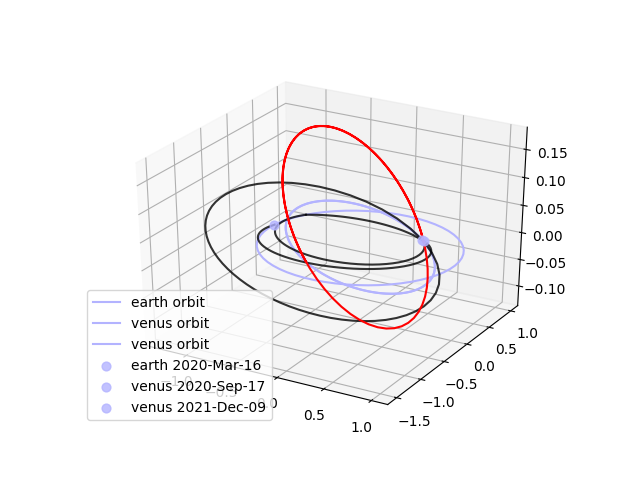

In [17]:
# Plot best result
solar_orbiter.plot(pop.champion_x)